Lone Hits Analysis
========================

lavoro con Francesco L. e Riccardo B.

[struttura dati straxen](https://straxen.readthedocs.io/en/latest/reference/datastructure.html)

è comodo usare **get_iter** per iterare sui vari chunck, si può chiamare anche più di un target però devono essere dello stesso tipo (guardare struttura dati); importante l'opzione **keep_column**

In [1]:
import sys
import os.path as osp

from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm  # use notebook-aware progress bar

In [2]:
st = straxen.contexts.xenonnt_online()

In [3]:
st.context_config['check_available'] = ('raw_records','pulse_counts','peaklets','lone_hits')

In [4]:
runs = st.select_runs(available=('lone_hits'),run_mode='*selftrigger*')

Checking data availability: 100%|██████████| 4/4 [03:33<00:00, 53.45s/it]


In [5]:
runs

,name,number,mode,start,end,tags,livetime,tags.name,peaklets_available,lone_hits_available,pulse_counts_available,raw_records_available
20,007178,7178,xenonnt_selftrigger_commissioning,2020-04-01 08:55:05.699,2020-04-01 09:10:08.602,,00:15:02.903000,NaN,True,True,True,False
21,007179,7179,xenonnt_selftrigger_commissioning,2020-04-01 09:10:41.945,2020-04-01 09:25:42.263,,00:15:00.318000,NaN,True,True,True,False
47,007205,7205,xenonnt_selftrigger_commissioning,2020-04-09 12:51:46.196,2020-04-09 12:55:33.618,,00:03:47.422000,NaN,True,True,True,False
78,007236,7236,xenonnt_selftrigger_commissioning,2020-04-17 17:36:57.991,2020-04-17 18:36:59.973,,01:00:01.982000,NaN,True,True,True,False
79,007237,7237,xenonnt_selftrigger_commissioning,2020-04-17 18:37:27.301,2020-04-17 19:37:29.723,,01:00:02.422000,NaN,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1289,008447,8447,xenonnt_selftrigger_commissioning_lowe,2020-06-28 07:26:33.785,2020-06-28 08:26:35.128,,01:00:01.343000,NaN,True,True,True,False
1290,008448,8448,xenonnt_selftrigger_commissioning_lowe,2020-06-28 08:26:49.213,2020-06-28 09:26:49.586,,01:00:00.373000,NaN,True,True,True,False
1291,008449,8449,xenonnt_selftrigger_commissioning_lowe,2020-06-28 09:27:03.678,2020-06-28 10:27:04.702,,01:00:01.024000,NaN,True,True,True,False
1292,008450,8450,xenonnt_selftrigger_commissioning_lowe,2020-06-28 10:27:18.796,2020-06-28 11:27:20.190,,01:00:01.394000,NaN,True,True,True,False


In [6]:
st.data_info('lone_hits')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,area,float32,Integral [ADC x samples]
5,left,int16,Index of sample in record in which hit starts
6,right,int16,Index of first sample in record just beyond hi...
7,left_integration,int16,"For lone hits, index of sample in record where..."
8,right_integration,int16,"For lone hits, index of first sample beyond in..."
9,record_i,int32,Internal (temporary) index of fragment in whic...


In [7]:
run_id = '008449'
#lone_hits = st.get_array(run_id,'lone_hits')
pdata = st.get_array(run_id,'lone_hits',max_workers=20,_chunk_number=2)

Text(0, 1, 'counts')

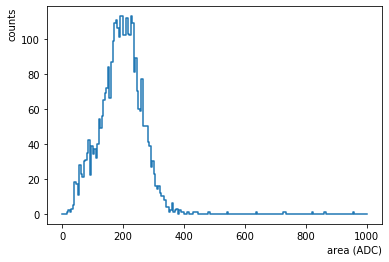

In [8]:
area = Hist1d(pdata['area'][pdata['channel']==1],bins=200,range=(0,1000))
area.plot()
plt.xlabel('area (ADC)', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)

Calcolo del Gain
-------------------
il PMT ha in uscita un impulso di corrente che se integrata nel tempo dà la carica rilasciata totale (Q), quindi il numero di elettroni che arrivano al PMT:

$Q=n\cdot e^-=\int_0^{t*} i(t) dt = \int_0^{t*} \frac{V(t)}{R} dt$

Il gain è uguale alla carica in uscita diviso la carica dell'elettrone, per calcolarlo poi bisogna tenere conto della conversione da canali ADC in corrente.

* $V_{max} = 2.25~$V (ampiezza in volt del'ADC)
* $n_{samples} = 2^{14}$ (n. samples)
* $R_{cavo} = 50~\Omega$ (impedenza del cavo)
* $dt = 10~$ns ()
* $e^- = 1.6\cdot 10^{-19}~$C
* $V_{max}/n_{samples}/R_{cavo}/dt/e^-$

In [45]:
def gain(id):
    conv=2.25/2**14/50/10*10e-9/1.6e-19
    plt.hist(pdata['area'][pdata['channel']==id]*conv,
             bins=200,range=(0,1e7),label=f"PMT n. {id}",
            histtype='step')
    plt.xlabel('gain')
    plt.ylabel('counts', ha='right', y=1)
    plt.yscale('log')
    #plt.legend()

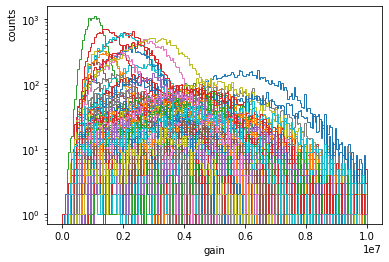

In [47]:
for i in range(100):
    gain(i)